# discrete_tf - Example2

Very simple discrete transfer function. The Python code should be platform agnostic, `ctypes` will load the appropriate shared library. 

- This example validates the transfer function numerator and denominator againsnt `python-control`
- Generates a step response with the default transfen function $\frac{3}{2s+1}$
- Simulate a sine-wave input through the Simulink model & compare it to `python-control` forced response.
- Configure the model with the transfer function $\frac{1}{1s+1}$ and plot a step response. Compare the step response to the `python-control` forced-response with the same input.

![](discrete_tf.png)

# Python Setup

In [1]:
import ctypes
import os
import platform

import matplotlib.pyplot as plt
import pandas as pd
from rtwtypes import *

Platform Specific Code. This is the only section of the code base that needs to be written specifically for the platform. After the  

In [2]:
if platform.system() == "Linux":
    dll_path = os.path.abspath("discrete_tf.so")
    dll = ctypes.cdll.LoadLibrary(dll_path)
elif platform.system() == "Windows":
    dll_path = os.path.abspath(f"discrete_t_win64.dll")
    dll = ctypes.windll.LoadLibrary(dll_path)

Platform Agnostic Setup:

In [3]:
# Model entry point functions
model_initialize = dll.discrete_tf_initialize
model_step = dll.discrete_tf_step
model_terminate = dll.discrete_tf_terminate

# Input Parameters
InputSignal = real_T.in_dll(dll, "InputSignal")
num = (real_T * 2).in_dll(dll, "num")
den = (real_T * 2).in_dll(dll, "den")
# Output Signals
OutputSignal = real_T.in_dll(dll, "OutputSignal")
SimTime = real_T.in_dll(dll, "SimTime")

Validate that the transfer function numerator and denominator generated in Matlab match those generated with Python tools.

```
matlab tf() -> 
matlab c2d() -> 
Simulink Tunable Parameter -> 
dll -> 
Python == control.c2d(control.TransferFunction)
```

In [4]:
import control
import numpy as np

# How fast the simulink model is running.
Ts = 1e-3
# Static Gain
K = 3
# Time Constant.
tau = 2
sys = control.TransferFunction([K], [tau, 1])
sysd = control.c2d(sys, Ts)
sysd

TransferFunction(array([0.00149963]), array([ 1.        , -0.99950012]), 0.001)

In [5]:
list(num)

[0.0, 0.0014996250624921886]

In [6]:
list(den)

[1.0, -0.9995001249791693]

In [7]:
np.isclose(num[1], sysd.num)

array([[[ True]]])

In [8]:
np.isclose(den[:], sysd.den)

array([[[ True,  True]]])

# Running The Model.

Run the model and store the step, input, output and simulation time to a pandas dataframe.

In [9]:
model_initialize()
rows = list()
for step in range(1000):
    model_step()
    rows.append(
        {
            "time": float(SimTime.value),
            "input": float(InputSignal.value),
            "output": float(OutputSignal.value),
        }
    )

In [10]:
df = pd.DataFrame(rows)
df

,time,input,output
0,0.000,0.0,0.0
1,0.001,0.0,0.0
2,0.002,0.0,0.0
3,0.003,0.0,0.0
4,0.004,0.0,0.0
...,...,...,...
995,0.995,0.0,0.0
996,0.996,0.0,0.0
997,0.997,0.0,0.0
998,0.998,0.0,0.0


# Step Response

Generate a step response to test the transfer function.

Unit step @ 1s.

In [11]:
model_initialize()
InputSignal.value = 0.0
data = list()
for step in range(int(15 * 1e3)):
    # If Time is >=1s, Input signal = 1s.
    if step >= 1 * 1e3:
        InputSignal.value = 1.0
    else:
        InputSignal.value = 0.0
    model_step()
    # Log the response.
    data.append(
        {
            "time": float(SimTime.value),
            "input": float(InputSignal.value),
            "output": float(OutputSignal.value),
        }
    )
df = pd.DataFrame(data)
df

,time,input,output
0,0.000,0.0,0.000000
1,0.001,0.0,0.000000
2,0.002,0.0,0.000000
3,0.003,0.0,0.000000
4,0.004,0.0,0.000000
...,...,...,...
14995,14.995,1.0,2.997258
14996,14.996,1.0,2.997259
14997,14.997,1.0,2.997260
14998,14.998,1.0,2.997262


<AxesSubplot:xlabel='time'>

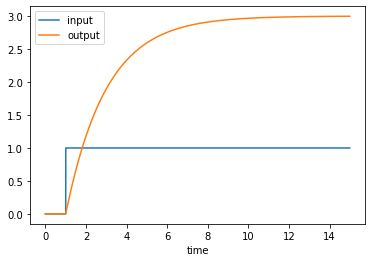

In [12]:
df.plot(x="time", y=["input", "output"])

Plot the ```control.forced_response``` for the same given input.

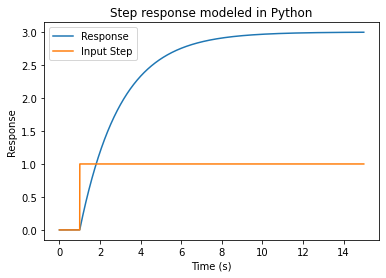

In [13]:
T, yout = control.forced_response(sysd, df.time, df.input)

plt.plot(T, yout, T, df.input)
plt.legend(["Response", "Input Step"])
plt.xlabel("Time (s)")
plt.ylabel("Response")
plt.title("Step response modeled in Python");

Find the max error between the Simulink step transfer function step response and the `control.forced_response` for the same input signal.

In [14]:
# Max error
np.max(yout - df.output)

7.620570841027074e-13

Sending the Simulink shared library has the same response to the same signal tested with the `python-control` library.

# Sinewave Input

Generate a sinewave with ``numpy``. Plot the input and output of the transfer function with ``pandas``.

<AxesSubplot:xlabel='time'>

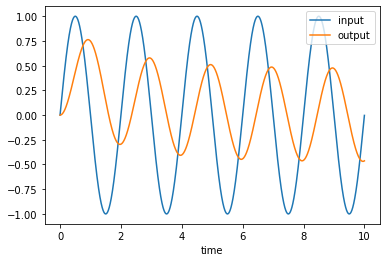

In [15]:
model_initialize()
rows = list()
f = 0.5  # Hz
Ts = 1e-3
for step in range(int(10 * 1e3)):
    InputSignal.value = np.sin(2 * np.pi * step * f * Ts)
    row_tmp = {
        "step": model_step(),
        "time": float(SimTime.value),
        "input": float(InputSignal.value),
        "output": float(OutputSignal.value),
    }
    rows.append(row_tmp)
df = pd.DataFrame(rows)
df.plot(x="time", y=["input", "output"])

Generate a forced response with `python-control` and compare it to the Simulink model's response.

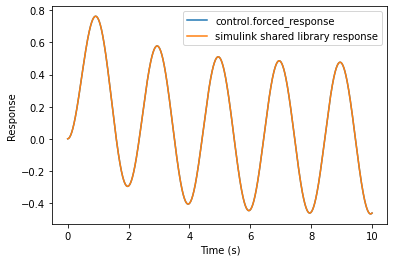

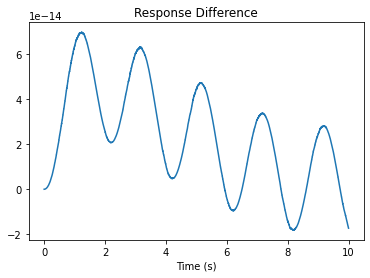

In [16]:
T, yout = control.forced_response(sysd, df.time, df.input)
plt.figure()
plt.plot(T, yout, df.time, df.output)
plt.xlabel("Time (s)")
plt.ylabel("Response")
plt.legend(["control.forced_response", "simulink shared library response"])
plt.figure()
plt.plot(T, (yout - df.output))
plt.xlabel("Time (s)")
plt.title("Response Difference");

# Changing the TransferFunction

Change the transfer function to have a static gain of 1 and a timeconstant of 1s.

Mark $1\tau$ and $2\tau$ on the graph.

In [17]:
# How fast the simulink model is running.
Ts = 1e-3
# Static Gain
K = 1
# Time Constant.
tau = 1
sys = control.TransferFunction([K], [tau, 1])
sysd = control.c2d(sys, Ts)
sysd

TransferFunction(array([0.0009995]), array([ 1.       , -0.9990005]), 0.001)

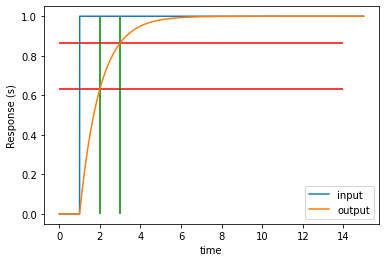

In [18]:
num[1] = sysd.num[0][0][0]
den[0] = sysd.den[0][0][0]
den[1] = sysd.den[0][0][1]

model_initialize()
InputSignal.value = 0.0
rows = list()
for step in range(int(15 * 1e3)):
    if step >= 1 * 1e3:
        InputSignal.value = 1.0
    else:
        InputSignal.value = 0.0
    row_tmp = {
        "step": model_step(),
        "time": float(SimTime.value),
        "input": float(InputSignal.value),
        "output": float(OutputSignal.value),
    }
    rows.append(row_tmp)
df = pd.DataFrame(rows)
df.plot(x="time", y=["input", "output"])
plt.ylabel("Response (s)")
plt.hlines([1 - np.exp(-tau), 1 - np.exp(-2 * tau)], xmin=0, xmax=14, colors="r")
plt.vlines([2, 3], ymin=0, ymax=1, colors="g")

## Validate Step Response

Using the characteristics of a first order transfer function test that the transfer function matches.

In [19]:
step_idx = np.where(df.input > 0)[0][0]
step_idx

1000

In [20]:
tau1_idx = np.where(df.output < (1 - np.exp(-1 * tau)))[0][-1]
tau2_idx = np.where(df.output < (1 - np.exp(-2 * tau)))[0][-1]

In [21]:
assert np.equal(df.time[tau1_idx] - df.time[step_idx], tau)
assert np.equal(df.time[tau2_idx] - df.time[step_idx], 2 * tau)